In [2]:
% matplotlib inline

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('white')

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [3]:
from glob import glob 
import os
from tqdm import tqdm_notebook as tqdm 
from itertools import product

import numpy as np
import scipy.ndimage
import cv2
from multiprocessing import Pool

import sys
sys.path.append('../scripts')
sys.path.append('../nets')
import load_utils
import watereshed
import generator_3D
import unet

from keras.callbacks import ModelCheckpoint
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


from skimage import measure
from skimage.morphology import convex_hull_image

import pickle
from skimage.measure import regionprops

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
PATHS = {
    'DATA': '/home/ubuntu/cdata/DM_Data/RIII',
    'DESC': '/home/ubuntu/cdata/DM_Data/REPRISEIIISizes.xlsx'
}


SIDE = 224
BATCH_SIZE = 32
SPLIT = .15

In [8]:
valve_df = pd.read_csv('../valve.csv')
labels_df = pd.read_excel('../../DM_Data/REPRISE III Sizes.xlsx')
test = valve_df.seriesuid.isin(labels_df['Subject name or identifier'])
paths = valve_df.seriesuid.apply(lambda x: os.path.join(PATHS['DATA'], x)).values
train = paths[True - test]
test = paths[test]
zis_paths = {os.path.basename(path): os.path.join(path, 'zis.npy') for path in paths}
prods_paths = {os.path.basename(path): os.path.join(path, 'prods.npy') for path in paths}

In [7]:
from IPython.display import clear_output

In [17]:
[i - 1 for i, el in enumerate(paths) if os.path.basename(el) in ['0938R3006', '0127R3138', '0261R3002', '1649R3011', '0127R3017', '0841R3005', '0159R3004', '1019R3003', '0127R3068', '0841R3062']]

[0, 40, 81, 86, 138, 149, 183, 190, 243]

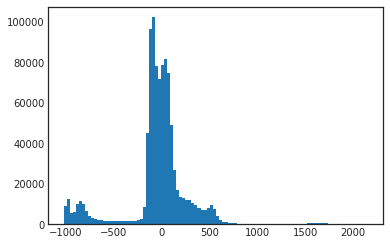

In [21]:
bins, vals, _ = plt.hist(
    patient[
        :mask.shape[0], 
        :mask.shape[1], 
        :mask.shape[2]
    ][mask[:patient.shape[0], :patient.shape[1], :patient.shape[2]]], 
    100
)

In [10]:
linspace_1d = np.vectorize(np.linspace)


def multi_linespace(start, stop, length=50):
    shape = start.shape
    start = start.flatten()
    stop = stop.flatten()
    lspace = np.array([np.linspace(v, e, length) for v, e in np.stack([start, stop]).T])
    return lspace.reshape(shape + (-1, ))

In [9]:
path = paths[5]
length = 224
width = 18

cpred = np.load(os.path.join('/home/ubuntu/edata/', os.path.basename(path), 'valve_mask.npy'))
cdilated  = np.load(os.path.join('/home/ubuntu/edata/', os.path.basename(path), 'valve_mask_dilated.npy'))
mask = np.load(os.path.join('/home/ubuntu/edata/', os.path.basename(path), 'mask.npy'))
patient = np.load(os.path.join('/home/ubuntu/edata/', os.path.basename(path), 'patient.npy'))

In [15]:
# patient = patient * mask
coords = np.array(np.where(cdilated)).T
origin = coords[np.random.randint(len(coords))]

normal = np.random.uniform(-1, 1, size=6).reshape(2, 3)
normal = np.stack([np.cross(normal[0], normal[1]), normal[0], normal[1]])
normal = np.array([length / 2, length / 2, width / 2]) * normal / np.expand_dims(np.linalg.norm(normal, ord=2, axis=1), -1)

lz = multi_linespace((-normal[0] / 2 + origin), (normal[0] / 2 + origin), length)
lz = multi_linespace((lz.T - normal[1] / 2), (lz.T + normal[1] / 2), length)
lz = np.rollaxis(lz, 1, 0)
lz = multi_linespace((lz.T - normal[2] / 2), (lz.T + normal[2] / 2), width)
lz = np.rollaxis(lz, 1, 0).reshape(3, -1)

zi = scipy.ndimage.map_coordinates(patient, lz)
zi = zi.reshape((length, length, width))


# zi = cv2.resize(zi, dsize=(SIDE, SIDE))
# zi = (np.expand_dims(zi, -1) + 199.) / 461.
# zis.append(zi)

# mi = scipy.ndimage.map_coordinates(lpred.astype(np.float), lz)
# mi = mi.reshape((length, length))
# mis.append(np.expand_dims(mi, -1))

# prods.append(lz)

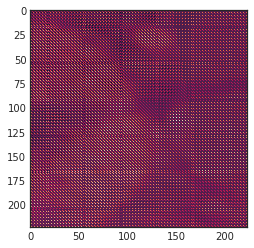

In [16]:
plt.imshow(zi[..., 10])

In [479]:
init_p = np.poly1d(p.coefficients)
length = min(min(patient.shape[1:]), 224)
step_size = .5

deriv_p = init_p.deriv()
point = np.array([x.min() + 20, init_p(x.min() + 20)])
points = [point]

while points[-1][0] <= x.max():
    v = np.array([1, deriv_p(point[0] + 1)])
    v = step_size * v / np.linalg.norm(v, ord=2)
    point = points[-1] + v
    point = np.array([point[0], p(point[0])])
    points.append(point)

points = np.array(points)

zis = list()
mis = list()
prods = list()

for point in tqdm(points[:, 0]):
    v = np.array([1, cp(point + 1) - cp(point), init_p(point + 1) - init_p(point)])
    v = np.stack([np.cross(v, np.array([0, 1, 0])), v])
    v = np.stack([np.cross(v[0], v[1]), v[0]])
    v = length * v / np.expand_dims(np.linalg.norm(v, ord=2, axis=1), -1)

    origin = np.array([point, cp(point), init_p(point)])

    lz = multi_linespace((-v[0] / 2 + origin), (v[0] / 2 + origin), length)
    lz = multi_linespace((lz.T - v[1] / 2), (lz.T + v[1] / 2), length)
    lz = np.rollaxis(lz, 1, 0).reshape(3, -1)

    zi = scipy.ndimage.map_coordinates(patient, lz)
    zi = zi.reshape((length, length))
    zi = cv2.resize(zi, dsize=(SIDE, SIDE))
    zi = (np.expand_dims(zi, -1) + 199.) / 461.
    zis.append(zi)
    
    mi = scipy.ndimage.map_coordinates(lpred.astype(np.float), lz)
    mi = mi.reshape((length, length))
    mis.append(np.expand_dims(mi, -1))
    
    prods.append(lz)
    

HBox(children=(IntProgress(value=0, max=147), HTML(value='')))

In [480]:
zis = np.stack(zis, 0)
mis = np.stack(mis, 0)

p = model.predict(zis)
p1 = model.predict(np.flip(zis, 1))
p2 = model.predict(np.flip(zis, 2))
p3 = model.predict(np.flip(np.flip(zis, 1), 2))

pred = np.mean(
    np.stack([
        p, 
        np.flip(p1, 1), 
        np.flip(p2, 2), 
        np.flip(np.flip(p3, 1), 2)
    ], -1), 
    -1
)

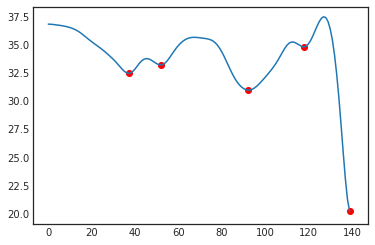

In [481]:
tangs = list()
large = list()
small = list()
for mi in pred[..., 0]:
    mask, _ = scipy.ndimage.label(mi > .5)
    try:
        idx = np.argmax(np.bincount(mask.flatten())[1:]) + 1
        mask = mask == idx
        rgroup = regionprops(mask.astype(np.int))[0]
        large.append(rgroup.major_axis_length * length / SIDE)
        small.append(rgroup.minor_axis_length * length / SIDE)
    except:
        tangs.append(0)
        continue

l = np.array([0 if np.isnan(l) or np.isnan(s) else l for l, s in zip(large, small)])
s = np.array([0 if np.isnan(l) or np.isnan(s) else s for l, s in zip(large, small)])

tangs = l
tangs = scipy.ndimage.gaussian_filter1d(tangs, 3)
args = scipy.signal.argrelextrema(tangs, np.less_equal, order=1)[0]
args = args[tangs[args] > 5]

plt.plot(np.arange(len(tangs)), tangs)
plt.scatter(args, tangs[args], c='r')
plt.show()

280 0841R3052


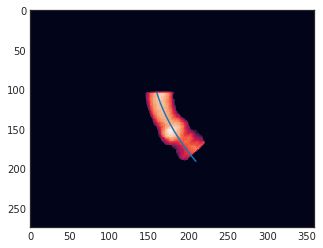

HBox(children=(IntProgress(value=0, max=161), HTML(value='')))

In [62]:
for i in range(280, 300):
    print(i, os.path.basename(train[i]))
    patient, meta = load_utils.load_patient(PATHS['DATA'], os.path.basename(train[i]), metadata=True)
    fact = meta['PixSpac']

    pred = glob(os.path.join(PATHS['DATA'], os.path.basename(train[i]), '*_A.stl'))
    pred = load_utils.load_mesh(pred[0], meta) 
    pred = np.expand_dims(pred, -1)
    
    pred = pred[..., 0]
#     pred = postprocess_test(pred[..., 0] > .5, patient)
    patient = scipy.ndimage.zoom(patient, fact, order=3)
    pred = scipy.ndimage.zoom(pred, fact, order=0)
    

    lpred, _ = scipy.ndimage.label(pred > .5)
    idx = np.argmax(np.bincount(lpred.flatten())[1:]) + 1
    lpred[lpred != idx] = 0
    lpred = scipy.ndimage.binary_closing(lpred, iterations=5)

    x, y = np.asarray(np.where(lpred))[[0, 2]]
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)

    init_d = p.deriv()
    opt = p(init_d.roots)
    flipped = False
    if np.abs(p(x.min()) - opt) > np.abs(p(x.max()) - opt):
        flipped = True
        patient = np.flip(patient, 0)
        lpred = np.flip(lpred, 0)
        pred = np.flip(pred, 0)
        x, y = np.asarray(np.where(lpred))[[0, 2]]
        z = np.polyfit(x, y, 2)
        p = np.poly1d(z)

    summedx = (lpred).sum(1).astype(np.float)
    plt.imshow(summedx)

    xp = np.linspace(x.min(), x.max(), 100)
    plt.plot(p(xp), xp, '-');
    plt.show()

    cx, cy = np.asarray(np.where(lpred))[[0, 1]]
    cz = np.polyfit(cx, cy, 1)
    cp = np.poly1d(cz)



    init_p = np.poly1d(p.coefficients)
    length = min(min(patient.shape[1:]), 224)
    step_size = .5

    deriv_p = init_p.deriv()
    point = np.array([x.min() + 20, init_p(x.min() + 20)])
    points = [point]

    while points[-1][0] <= x.max():
        v = np.array([1, deriv_p(point[0] + 1)])
        v = step_size * v / np.linalg.norm(v, ord=2)
        point = points[-1] + v
        point = np.array([point[0], p(point[0])])
        points.append(point)

    points = np.array(points)

    zis = list()
    mis = list()
    prods = list()

    for point in tqdm(points[:, 0]):
        v = np.array([1, cp(point + 1) - cp(point), init_p(point + 1) - init_p(point)])
        v = np.stack([np.cross(v, np.array([0, 1, 0])), v])
        v = np.stack([np.cross(v[0], v[1]), v[0]])
        v = length * v / np.expand_dims(np.linalg.norm(v, ord=2, axis=1), -1)

        origin = np.array([point, cp(point), init_p(point)])

        lz = multi_linespace((-v[0] / 2 + origin), (v[0] / 2 + origin), length)
        lz = multi_linespace((lz.T - v[1] / 2), (lz.T + v[1] / 2), length)
        lz = np.rollaxis(lz, 1, 0).reshape(3, -1)

        zi = scipy.ndimage.map_coordinates(patient, lz)
        zi = zi.reshape((length, length))
        zi = cv2.resize(zi, dsize=(SIDE, SIDE))
        zi = (np.expand_dims(zi, -1) + 199.) / 461.
        zis.append(zi)
        prods.append(lz)

    zis = np.stack(zis, 0)
    prods = np.array(prods)
    break
    np.save(os.path.join(PATHS['DATA'], os.path.basename(train[i]), 'prods'), prods)
    np.save(os.path.join(PATHS['DATA'], os.path.basename(train[i]), 'zis'), zis)


233 1342R3019


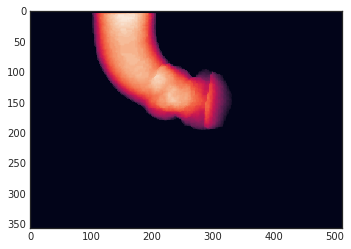

In [189]:
df = pd.read_csv('../valve.csv')
for i in range(233, 300):
    idxs = df[df.seriesuid == os.path.basename(train[i])][['idx0', 'idx1']]
    idxs = idxs.values[0]
    print(i, os.path.basename(train[i]))
    patient, meta = load_utils.load_patient(PATHS['DATA'], os.path.basename(train[i]), metadata=True)
    fact = meta['PixSpac']

    pred = glob(os.path.join(PATHS['DATA'], os.path.basename(train[i]), '*_A.stl'))
    pred = load_utils.load_mesh(pred[0], meta) 
    
    lpred, _ = scipy.ndimage.label(pred > .5)
    idx = np.argmax(np.bincount(lpred.flatten())[1:]) + 1
    lpred[lpred != idx] = 0
    lpred = scipy.ndimage.binary_closing(lpred, iterations=5)

    x, y = np.asarray(np.where(lpred))[[0, 2]]
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)

    init_d = p.deriv()
    opt = p(init_d.roots)
    flipped = False
    if np.abs(p(x.min()) - opt) > np.abs(p(x.max()) - opt):
        flipped = True
        patient = np.flip(patient, 0)
        lpred = np.flip(lpred, 0)
        pred = np.flip(pred, 0)
        x, y = np.asarray(np.where(lpred))[[0, 2]]
        z = np.polyfit(x, y, 2)
        p = np.poly1d(z)

    summedx = (lpred).sum(1).astype(np.float)
    plt.imshow(summedx)

    prods = np.load(os.path.join(PATHS['DATA'], os.path.basename(train[i]), 'prods.npy'))
    cpred = np.zeros_like(lpred)

    for i in range(idxs[0], idxs[1]):
        coords = np.array([prods[i][0], prods[i][1], prods[i][2]]) / np.expand_dims(fact, -1)
        coords = np.clip(coords.T, 0, np.array(lpred.shape) - 1)
        coords = np.round(coords).astype(np.int).T
        coords = tuple(c for c in coords)

        cpred[coords] = lpred[coords]

    cpred = scipy.ndimage.binary_closing(cpred, iterations=15) & lpred
    break

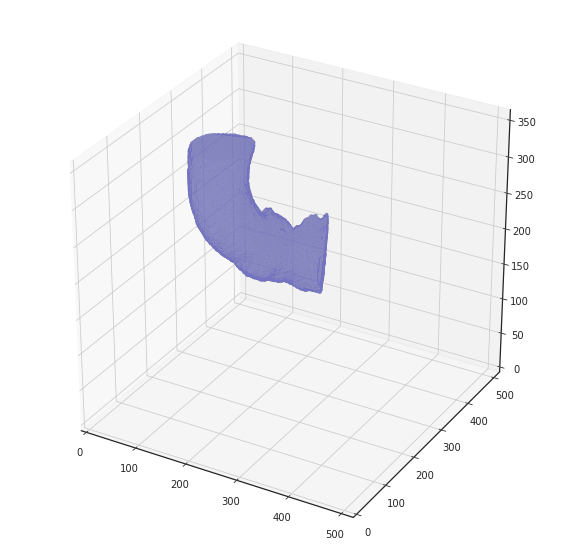

In [190]:
plot_3d(np.flip(lpred, 0), .5)

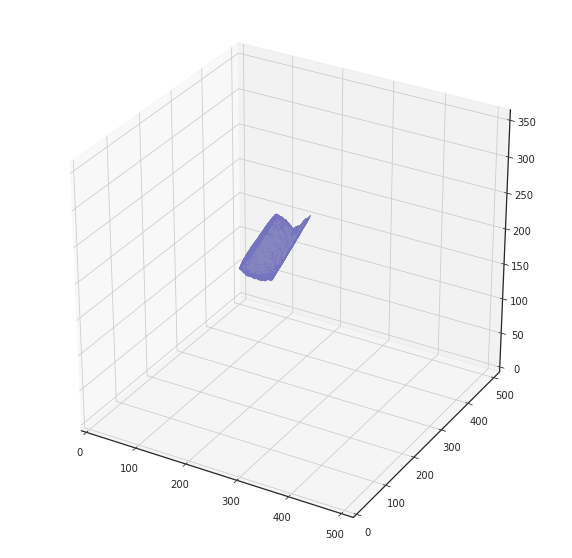

In [191]:
plot_3d(np.flip(cpred, 0), .5)

In [10]:
import numpy
from keras.layers import Convolution3D, Input, merge, RepeatVector, Activation
from keras.models import Model
from keras.layers.advanced_activations import PReLU
from keras import activations, initializers, regularizers
from keras.engine import Layer, InputSpec
from keras.utils.conv_utils import conv_output_length
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.engine.topology import Layer
import functools
import tensorflow as tf

In [11]:
from keras import backend as K
from keras.engine import Layer

class Softmax(Layer):
    def __init__(self, axis=-1,**kwargs):
        self.axis=axis
        super(Softmax, self).__init__(**kwargs)

    def build(self,input_shape):
        pass

    def call(self, x,mask=None):
        e = K.exp(x - K.max(x, axis=self.axis, keepdims=True))
        s = K.sum(e, axis=self.axis, keepdims=True)
        return e / s

    def get_output_shape_for(self, input_shape):
        return input_shape


In [12]:
def downward_layer(input_layer, n_convolutions, n_output_channels):
    inl = input_layer
    for _ in range(n_convolutions-1):
        inl = PReLU()(
            Convolution3D(n_output_channels // 2, 5, 5, 5, border_mode='same', dim_ordering='tf')(inl)
        )
    conv = Convolution3D(n_output_channels // 2, 5, 5, 5, border_mode='same', dim_ordering='tf')(inl)
    add = merge([conv, input_layer], mode='sum')
    downsample = Convolution3D(n_output_channels, 2,2,2, subsample=(2,2,2))(add)
    prelu = PReLU()(downsample)
    return prelu, add

In [21]:
def upward_layer(input0 ,input1, n_convolutions, n_output_channels):
    merged = merge([input0, input1], mode='concat', concat_axis=4)
    inl = merged
    for _ in range(n_convolutions-1):
        inl = PReLU()(
            Convolution3D(n_output_channels * 4, 5, 5, 5, border_mode='same', dim_ordering='tf')(inl)
        )
    conv = Convolution3D(n_output_channels * 4, 5, 5, 5, border_mode='same', dim_ordering='tf')(inl)
    add = merge([conv, merged], mode='sum')
    shape = add.get_shape().as_list()
    new_shape = (1, shape[1] * 2, shape[2] * 2, shape[3] * 2, n_output_channels)
    upsample = Deconvolution3D(n_output_channels, (4,4,4), new_shape, subsample=(2,2,2))(add)
    return PReLU()(upsample)

In [22]:
class Deconvolution3D(Layer):
    
    def __init__(self, nb_filter, kernel_dims, output_shape, subsample, **kwargs):
        self.nb_filter = nb_filter
        self.kernel_dims = kernel_dims
        self.strides = (1, ) + subsample + (1, )
        self.output_shape_ = output_shape
        assert K.backend() == 'tensorflow'
        super(Deconvolution3D, self).__init__(**kwargs)
        
    def build(self, input_shape):
        assert len(input_shape) == 5
        self.W = self.add_weight(shape=self.kernel_dims + (self.nb_filter, input_shape[4], ),
                                 initializer='glorot_uniform',
                                 name='{}_W'.format(self.name),
                                 trainable=True)
        self.b = self.add_weight(shape=(1, 1, 1, self.nb_filter,), 
                                 initializer='zero', 
                                 name='{}_b'.format(self.name),
                                 trainable=True)
        super(Deconvolution3D, self).build(input_shape) 

    def call(self, x, mask=None):
        return tf.nn.conv3d_transpose(x, self.W, output_shape=self.output_shape_,
                                      strides=self.strides, padding='SAME', name=self.name) + self.b

    def compute_output_shape(self, input_shape):
        return (input_shape[0], ) + self.output_shape_[1:]

In [24]:
# Layer 1
input_layer = Input(shape=(128, 128, 64, 1), name='data')
conv_1 = Convolution3D(16, 5, 5, 5, border_mode='same', dim_ordering='tf')(input_layer)
repeat_1 = merge([input_layer] * 16, mode='concat')
add_1 = merge([conv_1, repeat_1], mode='sum')
prelu_1_1 = PReLU()(add_1)
downsample_1 = Convolution3D(32, 2,2,2, subsample=(2,2,2))(prelu_1_1)
prelu_1_2 = PReLU()(downsample_1)

# Layer 2,3,4
out2, left2 = downward_layer(prelu_1_2, 2, 64)
out3, left3 = downward_layer(out2, 2, 128)
out4, left4 = downward_layer(out3, 2, 256)

# Layer 5
conv_5_1 = Convolution3D(256, 5, 5, 4, border_mode='same', dim_ordering='tf')(out4)
prelu_5_1 = PReLU()(conv_5_1)
conv_5_2 = Convolution3D(256, 5, 5, 4, border_mode='same', dim_ordering='tf')(prelu_5_1)
prelu_5_2 = PReLU()(conv_5_2)
conv_5_3 = Convolution3D(256, 5, 5, 4, border_mode='same', dim_ordering='tf')(prelu_5_2)
add_5 = merge([conv_5_3, out4], mode='sum')
prelu_5_1 = PReLU()(add_5)
downsample_5 = Deconvolution3D(128, (2,2,2), (1, 16, 16, 8, 128), subsample=(2,2,2))(prelu_5_1)
prelu_5_2 = PReLU()(downsample_5)

#Layer 6,7,8
out6 = upward_layer(prelu_5_2, left4, 3, 64)
out7 = upward_layer(out6, left3, 3, 32)
out8 = upward_layer(out7, left2, 2, 16)

#Layer 9
merged_9 = merge([out8, add_1], mode='concat', concat_axis=4)
conv_9_1 = Convolution3D(32, 5, 5, 5, border_mode='same', dim_ordering='tf')(merged_9)
add_9 = merge([conv_9_1, merged_9], mode='sum')
conv_9_2 = Convolution3D(2, 1, 1, 1, border_mode='same', dim_ordering='tf')(add_9)

softmax = Softmax()(conv_9_2)

model = Model(input_layer, softmax)

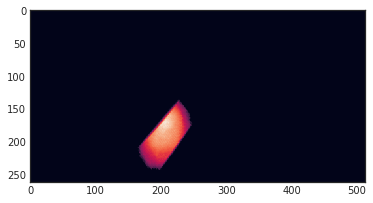

In [181]:
plt.imshow(cpred.sum(1))

In [148]:
predicts = pickle.load(open('../../DM_Data/predicts__', 'rb'))

In [217]:
sum([i[0] for i in predicts.values()]) / len(predicts)

0.6842105263157895

In [150]:
fd = pd.read_excel('../../DM_Data/REPRISE III Sizes.xlsx')
ctest = [t for t in test if (fd['Subject name or identifier'] == os.path.basename(t)).sum()]
diameters = np.array([23, 25, 27])
# predicts = dict()

for test_idx in range(len(predicts), len(ctest)):
    try:
        patient, meta = load_utils.load_patient(PATHS['DATA'], os.path.basename(ctest[test_idx]), metadata=True)
        row = fd[fd['Subject name or identifier'] == os.path.basename(ctest[test_idx])]
        fact = meta['PixSpac']
        try:
            test_gen = test_generator(patient)
            arr = np.concatenate([next(test_gen) for i in range(len(patient) // BATCH_SIZE + 1)])
            test_gen = test_generator(patient)
            p = model.predict_generator(test_gen, len(patient) // BATCH_SIZE + 1)
            test_gen = test_generator(np.flip(patient, 1))
            p1 = model.predict_generator(test_gen, len(patient) // BATCH_SIZE + 1)
            test_gen = test_generator(np.flip(patient, 2))
            p2 = model.predict_generator(test_gen, len(patient) // BATCH_SIZE + 1)
            test_gen = test_generator(np.flip(np.flip(patient, 1), 2))
            p3 = model.predict_generator(test_gen, len(patient) // BATCH_SIZE + 1)
        except:
            test_gen = test_generator(patient)
            arr = np.concatenate([next(test_gen) for i in range(len(patient) // BATCH_SIZE)])
            test_gen = test_generator(patient)
            p = model.predict_generator(test_gen, len(patient) // BATCH_SIZE)
            test_gen = test_generator(np.flip(patient, 1))
            p1 = model.predict_generator(test_gen, len(patient) // BATCH_SIZE)
            test_gen = test_generator(np.flip(patient, 2))
            p2 = model.predict_generator(test_gen, len(patient) // BATCH_SIZE)
            test_gen = test_generator(np.flip(np.flip(patient, 1), 2))
            p3 = model.predict_generator(test_gen, len(patient) // BATCH_SIZE)


        pred = np.mean(
            np.stack([
                p, 
                np.flip(p1, 1), 
                np.flip(p2, 2), 
                np.flip(np.flip(p3, 1), 2)
            ], -1), 
            -1
        )

        pred = postprocess_test(pred[..., 0] > .5, patient)
        patient = scipy.ndimage.zoom(patient, fact, order=3)
        pred = scipy.ndimage.zoom(pred, fact, order=0)


        lpred, _ = scipy.ndimage.label(pred > .5)
        idx = np.argmax(np.bincount(lpred.flatten())[1:]) + 1
        lpred[lpred != idx] = 0
        lpred = scipy.ndimage.binary_closing(lpred, iterations=5)

        x, y = np.asarray(np.where(lpred))[[0, 2]]
        z = np.polyfit(x, y, 2)
        p = np.poly1d(z)

        init_d = p.deriv()
        opt = p(init_d.roots)
        flipped = False
        if np.abs(p(x.min()) - opt) > np.abs(p(x.max()) - opt):
            flipped = True
            patient = np.flip(patient, 0)
            lpred = np.flip(lpred, 0)
            pred = np.flip(pred, 0)
            x, y = np.asarray(np.where(lpred))[[0, 2]]
            z = np.polyfit(x, y, 2)
            p = np.poly1d(z)

        summedx = (lpred).sum(1).astype(np.float)
        xp = np.linspace(x.min(), x.max(), 100)

        cx, cy = np.asarray(np.where(lpred))[[0, 1]]
        cz = np.polyfit(cx, cy, 1)
        cp = np.poly1d(cz)
        cxp = np.linspace(cx.min(), cx.max(), 100)


        length = min(min(patient.shape[1:]), 224)
        tangs = list()
        x_unique = np.unique(x)[30:]
        x_unique = np.concatenate([
            x_unique, 
            np.arange(x_unique.max() + 1, x_unique.max() + 21)
        ])
        init_p = np.poly1d(p.coefficients)
        zis = list()
        mis = list()

        for point in tqdm(x_unique):
            v = np.array([1, cp(point + 1) - cp(point), init_p(point + 1) - init_p(point)])
            v = np.stack([np.cross(v, np.array([0, 1, 0])), v])
            v = np.stack([np.cross(v[0], v[1]), v[0]])
            v = length * v / np.expand_dims(np.linalg.norm(v, ord=2, axis=1), -1)

            origin = np.array([point, cp(point), init_p(point)])

            lz = multi_linespace((-v[0] / 2 + origin), (v[0] / 2 + origin), length)
            lz = multi_linespace((lz.T - v[1] / 2), (lz.T + v[1] / 2), length)
            lz = np.rollaxis(lz, 1, 0).reshape(3, -1)

            zi = scipy.ndimage.map_coordinates(patient, lz)
            zi = zi.reshape((length, length))
            zi = cv2.resize(zi, dsize=(SIDE, SIDE))
            zi = (np.expand_dims(zi, -1) + 199.) / 461.
            zis.append(zi)

            mi = scipy.ndimage.map_coordinates(lpred.astype(np.float), lz)
            mi = mi.reshape((length, length))
            mis.append(np.expand_dims(mi, -1))


        zis = np.stack(zis, 0)
        mis = np.stack(mis, 0)

        p = model.predict(zis)
        p1 = model.predict(np.flip(zis, 1))
        p2 = model.predict(np.flip(zis, 2))
        p3 = model.predict(np.flip(np.flip(zis, 1), 2))

        pred = np.mean(
            np.stack([
                p, 
                np.flip(p1, 1), 
                np.flip(p2, 2), 
                np.flip(np.flip(p3, 1), 2)
            ], -1), 
            -1
        )


        tangs = list()
        large = list()
        small = list()
        for mi in pred[..., 0]:
            mask, _ = scipy.ndimage.label(mi > .5)
            try:
                idx = np.argmax(np.bincount(mask.flatten())[1:]) + 1
                mask = mask == idx
                rgroup = regionprops(mask.astype(np.int))[0]
                large.append(rgroup.major_axis_length * length / SIDE)
                small.append(rgroup.minor_axis_length * length / SIDE)
            except:
                tangs.append(0)
                continue

        tangs = np.array([0 if np.isnan(l) or np.isnan(s) else l for l, s in zip(large, small)])
        small = np.array([0 if np.isnan(l) or np.isnan(s) else s for l, s in zip(large, small)])

        tangs = scipy.ndimage.gaussian_filter1d(tangs, 3)
        args = scipy.signal.argrelextrema(tangs, np.less_equal, order=1)[0]
        args = args[small[args] > 5]
        tangs = small.copy()
        

        row = fd[fd['Subject name or identifier'] == os.path.basename(ctest[test_idx])]
        gt = int(row['Valve Size (Model number)'].values[0][:2])

        idxs = np.argmin(np.square([diameters - t for t in sorted([i for i in tangs[args] if i > 18])[:1]]), axis=1)
        vsp = diameters[idxs]
        pp = any(diameters[idxs] == gt)


        predicts[os.path.basename(ctest[test_idx])] = (pp, gt, vsp, sorted(tangs[args])[:3], tangs[args])
        print(os.path.basename(ctest[test_idx]) + ': ', pp, gt, vsp, sorted(tangs[args])[:3], tangs[args])
        pickle.dump(predicts, open('../../DM_Data/predicts__', 'wb'))
    except:
        print(test_idx, os.path.basename(ctest[test_idx]))

HBox(children=(IntProgress(value=0, max=99), HTML(value='')))


0303R3003:  True 23 [23 23 23] [10.457296419502294, 20.432245012232858, 21.144105340858264] [ 38.44144351  31.02205222  30.0701422   20.43224501  21.14410534
  10.45729642]


HBox(children=(IntProgress(value=0, max=97), HTML(value='')))


0780R3015:  True 27 [23 27 27] [15.368853850227534, 36.092078878828367, 46.811700194338009] [ 46.81170019  36.09207888  15.36885385]


HBox(children=(IntProgress(value=0, max=84), HTML(value='')))


1006R3037:  True 27 [27 27] [28.832444945332998, 35.605790053978716] [ 35.60579005  28.83244495]


HBox(children=(IntProgress(value=0, max=57), HTML(value='')))


0801R3010:  True 23 [23 23 27] [7.9844949291896636, 21.434558167400581, 29.951635119131719] [ 29.95163512  21.43455817   7.98449493]


HBox(children=(IntProgress(value=0, max=82), HTML(value='')))


0127R3004:  True 23 [23 27 27] [20.958437650961717, 28.132018730383408, 33.605375763600691] [ 33.60537576  28.13201873  20.95843765]


HBox(children=(IntProgress(value=0, max=57), HTML(value='')))


0763R3021:  False 25 [27 27] [26.881877636727719, 29.844758121599966] [ 26.88187764  29.84475812]


HBox(children=(IntProgress(value=0, max=80), HTML(value='')))


1019R3025:  True 23 [23 27 27] [20.041534325850893, 29.37267938343383, 30.160034893995537] [ 30.16003489  29.37267938  20.04153433]


HBox(children=(IntProgress(value=0, max=59), HTML(value='')))


1184R3012:  False 25 [23 23] [6.6076221722451365, 22.073640373249425] [ 22.07364037   6.60762217]


HBox(children=(IntProgress(value=0, max=75), HTML(value='')))


0304R3031:  True 27 [23 27 27] [16.049962320182129, 26.08007596646323, 28.60996085196286] [ 28.60996085  26.08007597  16.04996232]


HBox(children=(IntProgress(value=0, max=101), HTML(value='')))


0201R3006:  False 25 [23 27 27] [11.625892122644487, 32.010764085532941, 33.157752603004553] [ 35.26167211  32.01076409  33.1577526   11.62589212]


HBox(children=(IntProgress(value=0, max=95), HTML(value='')))


0159R3030:  True 23 [23 23 27] [8.2430844060506701, 21.975756450272332, 30.756579820301219] [ 30.75657982  21.97575645   8.24308441]


HBox(children=(IntProgress(value=0, max=91), HTML(value='')))


1006R3051:  True 25 [25 27 27] [25.514686958819201, 31.278148745060005, 31.568340070269972] [ 31.27814875  25.51468696  31.56834007]


HBox(children=(IntProgress(value=0, max=111), HTML(value='')))


0127R3012:  False 25 [23 23 27] [18.46598865104437, 22.899935578023321, 29.304157891399239] [ 29.30415789  22.89993558  32.3759161   18.46598865]


HBox(children=(IntProgress(value=0, max=74), HTML(value='')))


0763R3092:  True 27 [27 27] [27.396559888706005, 34.37241432735248] [ 27.39655989  34.37241433]


HBox(children=(IntProgress(value=0, max=89), HTML(value='')))


0863R3010:  True 23 [23 27] [18.673136908032017, 28.754265200944054] [ 28.7542652   18.67313691]


HBox(children=(IntProgress(value=0, max=97), HTML(value='')))


0127R3045:  True 23 [23 27 27] [17.848808949697172, 29.153175214699157, 30.051974610093506] [ 30.05197461  29.15317521  17.84880895]


HBox(children=(IntProgress(value=0, max=118), HTML(value='')))


0127R3030:  True 27 [23 25 27] [8.5420874921552752, 24.260090648961981, 30.426856746499816] [ 37.34300397  31.1760082   24.26009065  30.42685675   8.54208749]


HBox(children=(IntProgress(value=0, max=109), HTML(value='')))


0262R3004:  True 27 [23 27 27] [6.0870061242971447, 28.865252509871912, 30.38409060110002] [ 28.86525251  30.3840906    6.08700612]


HBox(children=(IntProgress(value=0, max=88), HTML(value='')))


0266R3036:  True 25 [23 23 25] [5.7409307089938713, 7.3058659462980158, 25.484765464700995] [ 31.58026494  25.48476546   7.30586595   5.74093071]


HBox(children=(IntProgress(value=0, max=80), HTML(value='')))


0304R3026:  False 25 [23 23 23] [18.365082618946197, 20.982678427725983, 23.960146715265257] [ 32.11925705  23.96014672  20.98267843  18.36508262]


HBox(children=(IntProgress(value=0, max=101), HTML(value='')))


0760R3006:  True 27 [23 27 27] [5.9114445168007697, 27.697429635352645, 30.655061952790458] [ 33.11000103  30.65506195  27.69742964   5.91144452]


HBox(children=(IntProgress(value=0, max=104), HTML(value='')))


0127R3035:  False 25 [23 23 23] [8.6611869512413246, 19.34611975782116, 23.343231100766996] [ 33.02301739  23.3432311   19.34611976   8.66118695]


HBox(children=(IntProgress(value=0, max=56), HTML(value='')))


0763R3105:  True 25 [23 25 27] [19.448839754612258, 25.022097673320211, 28.976819448545008] [ 25.02209767  28.97681945  19.44883975]


HBox(children=(IntProgress(value=0, max=80), HTML(value='')))


1006R3038:  True 27 [27 27] [29.61281438183703, 33.166032975850705] [ 29.61281438  33.16603298]


HBox(children=(IntProgress(value=0, max=87), HTML(value='')))


0266R3025:  False 25 [23 23 27] [22.345803299211962, 22.586935449014124, 28.608002198536923] [ 33.3321328   28.6080022   22.58693545  22.3458033   32.74949619]


HBox(children=(IntProgress(value=0, max=105), HTML(value='')))


0753R3012:  False 25 [27] [31.774362686637776] [ 31.77436269]


HBox(children=(IntProgress(value=0, max=101), HTML(value='')))


0458R3006:  True 25 [23 25 25] [18.249781437739671, 25.071996807654397, 25.476358138429553] [ 38.80778669  34.58201301  25.47635814  25.07199681  18.24978144]


HBox(children=(IntProgress(value=0, max=55), HTML(value='')))


1184R3017:  True 25 [23 25 27] [10.569472980295048, 24.91837574461638, 26.720806420652398] [ 24.91837574  26.72080642  10.56947298]


HBox(children=(IntProgress(value=0, max=69), HTML(value='')))


1184R3021:  True 25 [23 25 27] [20.532645669580337, 24.935163917063743, 29.588538817765862] [ 29.58853882  24.93516392  20.53264567]


HBox(children=(IntProgress(value=0, max=121), HTML(value='')))


0127R3007:  True 25 [23 25 27] [19.828302482130407, 24.735519672007989, 33.66574635296287] [ 36.41956728  33.66574635  24.73551967  19.82830248]


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


0763R3094:  False 25 [23 27 27] [10.473281562899221, 28.414823411800313, 35.077155070418009] [ 28.41482341  35.07715507  10.47328156]


HBox(children=(IntProgress(value=0, max=49), HTML(value='')))


1006R3077:  True 23 [23] [22.291824989911529] [ 22.29182499]


HBox(children=(IntProgress(value=0, max=93), HTML(value='')))


0201R3004:  True 23 [23 23 27] [12.730823704569769, 23.870166558508391, 30.494921124728091] [ 34.84248655  30.49492112  23.87016656  12.7308237 ]


HBox(children=(IntProgress(value=0, max=94), HTML(value='')))


1006R3017:  False 25 [23 23 23] [9.3961901032561297, 21.239304320500747, 21.609272515122917] [ 28.4427585   21.60927252   9.3961901   21.23930432]


HBox(children=(IntProgress(value=0, max=82), HTML(value='')))


0262R3018:  False 25 [23 27 27] [23.600804084166018, 26.372870805679831, 34.658241122483268] [ 38.53787727  34.65824112  26.37287081  23.60080408]


HBox(children=(IntProgress(value=0, max=86), HTML(value='')))


0123R3034:  False 25 [27 27] [26.795319347589576, 31.637723363327392] [ 31.63772336  26.79531935]


HBox(children=(IntProgress(value=0, max=112), HTML(value='')))


0127R3063:  True 27 [27 27 27] [26.905649938872838, 32.603062922687378, 36.145408613818638] [ 38.0843515   32.60306292  26.90564994  36.14540861]


HBox(children=(IntProgress(value=0), HTML(value='')))


0972R3009:  False 25 [23 27] [21.536970131945367, 34.785286863377138] [ 34.78528686  21.53697013]


HBox(children=(IntProgress(value=0, max=123), HTML(value='')))


0262R3005:  True 25 [23 23 25] [7.8520334106067589, 8.9493772900631381, 25.250755223725008] [ 27.8593329   25.25075522   8.94937729   7.85203341]


HBox(children=(IntProgress(value=0, max=64), HTML(value='')))


1006R3052:  True 27 [23 27 27] [17.990903347782343, 27.902124699025432, 28.560879160506289] [ 28.56087916  27.9021247   17.99090335]


HBox(children=(IntProgress(value=0, max=95), HTML(value='')))


0111R3004:  True 23 [23 23 27] [21.301218876620371, 23.399834893889469, 27.343181386881305] [ 31.50470842  27.34318139  23.39983489  21.30121888]


HBox(children=(IntProgress(value=0, max=73), HTML(value='')))


0679R3024:  True 25 [25 27 27] [25.713760455192112, 29.379852823898016, 30.436594362308586] [ 30.43659436  25.71376046  31.76645146  29.37985282]


HBox(children=(IntProgress(value=0, max=94), HTML(value='')))


0679R3013:  True 23 [23 23 27] [11.502683277096159, 21.191917021688408, 30.337232128001705] [ 33.74807518  30.33723213  21.19191702  11.50268328]


HBox(children=(IntProgress(value=0, max=92), HTML(value='')))


1649R3010:  False 25 [23 23 27] [7.0871856961864728, 21.602005469758556, 33.170358413188673] [ 33.17035841  21.60200547   7.0871857 ]


HBox(children=(IntProgress(value=0, max=101), HTML(value='')))


1342R3014:  False 27 [23 23 25] [12.811931440172481, 14.760378299657377, 25.701808682785135] [ 38.85307476  33.60633184  25.70180868  14.7603783   12.81193144]


HBox(children=(IntProgress(value=0, max=69), HTML(value='')))


0104R3012:  False 25 [23 23 27] [7.6440174560788297, 22.054635893652229, 28.352727652933389] [ 28.35272765  22.05463589   7.64401746]


HBox(children=(IntProgress(value=0, max=81), HTML(value='')))


1649R3007:  True 27 [23 27 27] [9.5185223904747769, 29.178886826003907, 38.59159055861015] [ 39.92413644  40.02867838  38.59159056  29.17888683   9.51852239]


HBox(children=(IntProgress(value=0, max=84), HTML(value='')))


0760R3012:  True 27 [23 23 27] [21.425567938725926, 21.562047577340955, 26.167008149980713] [ 27.41131427  26.16700815  21.56204758  21.42556794]


HBox(children=(IntProgress(value=0, max=111), HTML(value='')))


1019R3017:  False 25 [23 23 27] [10.381248398865969, 19.890481342456088, 34.211421235692427] [ 19.89048134  34.21142124  10.3812484 ]


HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

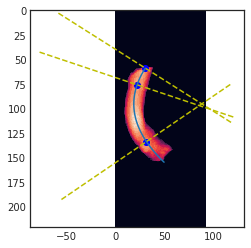

In [546]:
shift = np.array(patient.shape[1:]) // 2 - length // 2
shift = np.clip(shift, 0, np.array(patient.shape[1:]) - length)

plt.imshow(summedx)
plt.plot(init_p(xp), xp, '-');

zis = list()
mis = list()
prods = list()
for point in tqdm(x_unique[args].tolist()):
    v = np.array([1, cp(point + 1) - cp(point), init_p(point + 1) - init_p(point)])
    v = np.stack([np.cross(v, np.array([0, 1, 0])), v])
    v = np.stack([np.cross(v[0], v[1]), v[0]])
    v = length * v / np.expand_dims(np.linalg.norm(v, ord=2, axis=1), -1)

    origin = np.array([point, cp(point), init_p(point)])

    clz = multi_linespace((-v[1] / 2 + origin), (v[1] / 2 + origin), length)
    lz = multi_linespace((clz.T - v[0] / 2), (clz.T + v[0] / 2), length)
    
    plt.plot(clz[2, [0, -1]], clz[0, [0, -1]], '--', c='y');
    lz = np.rollaxis(lz, 1, 0).reshape(3, -1)

    plt.scatter(init_p(point), point, c='b')
    
    mi = scipy.ndimage.map_coordinates(lpred.astype(np.float), lz)
    mi = mi.reshape((length, length))
    mi = cv2.resize(mi, dsize=(SIDE, SIDE))
    mi = (np.expand_dims(mi, -1) + 199.) / 461.
    mis.append(mi)
    
    zi = scipy.ndimage.map_coordinates(patient, lz)
    zi = zi.reshape((length, length))
    zi = cv2.resize(zi, dsize=(SIDE, SIDE))
    zi = (np.expand_dims(zi, -1) + 199.) / 461.
    zis.append(zi)


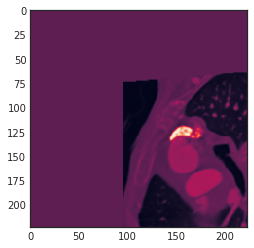

Diameter: 28.7681369588
Diameter convex hull: 29.7686869569


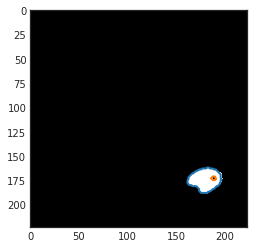

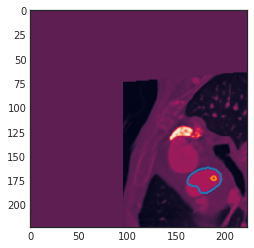

In [526]:
i = 0

plt.imshow(zis[i, ..., 0])
plt.show()

from skimage import measure
from skimage.morphology import convex_hull_image

coeff = SIDE / length
 
# Find contours at a constant value of 0.8
mask = pred[i, ..., 0] > .5
mask, _ = scipy.ndimage.label(mask)
idx = np.argmax(np.bincount(mask.flatten())[1:]) + 1
mask = mask == idx
cmask = convex_hull_image(mask)
print('Diameter:', 2 * np.sqrt(mask.sum() / np.pi))
print('Diameter convex hull:', 2 * np.sqrt(cmask.sum() / np.pi))
contours = measure.find_contours(mask, .9)


# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(mask, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
plt.show()

plt.imshow(zis[i, ..., 0])
for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

plt.show()

# Hard negative mining

In [ ]:
model = unet.get_unet(224, 224)
model.load_weights(os.path.join(PATHS['DATA'], 'unet_model'))

In [ ]:
def np_dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return ( (2. * intersection + smooth) / 
             (np.sum(y_true_f) + np.sum(y_pred_f) + smooth) )

In [ ]:
for t in tqdm(train):
    patient, meta = load_utils.load_patient(PATHS['DATA'], os.path.basename(t), metadata=True)
    meshs = glob(os.path.join(PATHS['DATA'], os.path.basename(t), '*_A.stl'))
    meshs = load_utils.load_mesh(meshs[0], meta) 
    meshs = meshs[:patient.shape[0], :patient.shape[1], :patient.shape[2]]
    patient = np.stack([patient, meshs], -1)
    test_gen = eval_generator(patient, batch_size=len(patient))
    cgen = next(test_gen)
    valeval = model.predict(cgen[0], 32)
    valeval = np.array([np_dice_coef(cgen[1][i], valeval[i]) for i in range(len(valeval))])
    np.save(os.path.join(t, 'dice'), valeval)
    print(os.path.join(t, 'dice'))
    break